<a href="https://colab.research.google.com/github/coder-jkb/ML-projects/blob/main/CURE_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Kchu/CURE-cluster-python.git

Cloning into 'CURE-cluster-python'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 57 (delta 10), reused 22 (delta 7), pack-reused 30
Receiving objects: 100% (57/57), 108.47 KiB | 881.00 KiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
!dir

CURE-cluster-python  sample_data


In [3]:
%cd "CURE-cluster-python"
!pwd

/content/CURE-cluster-python
/content/CURE-cluster-python


# Implementation of CURE (Clustering Using Representatives) Algorithm

In [1]:
import numpy as np
import scipy.spatial.distance as distance
import sys

## Calculate Eudlidean distance between two vectors

In [2]:
def dist(vecA, vecB):
    return np.sqrt(np.power(vecA - vecB, 2).sum())


## The `class` to describe the data structure and method of operation for CURE clustering.

In [3]:
class CureCluster:
    def __init__(self, id__, center__):
        self.points = center__
        self.repPoints = center__
        self.center = center__
        self.index = [id__]

    def __repr__(self):
        return "Cluster " + " Size: " + str(len(self.points))

    # Computes and stores the centroid of this cluster, based on its points
    def computeCentroid(self, clust):
        totalPoints_1 = len(self.index)
        totalPoints_2 = len(clust.index)
        self.center = (self.center*totalPoints_1 + clust.center*totalPoints_2) / (totalPoints_1 + totalPoints_2)

    # Computes and stores representative points for this cluster
    def generateRepPoints(self, numRepPoints, alpha):
        tempSet = None
        for i in range(1, numRepPoints+1):
            maxDist = 0
            maxPoint = None
            for p in range(0, len(self.index)):
                if i == 1:
                    minDist = dist(self.points[p,:], self.center)
                else:
                    X = np.vstack([tempSet, self.points[p, :]])
                    tmpDist = distance.pdist(X)
                    minDist = tmpDist.min()
                if minDist >= maxDist:
                    maxDist = minDist
                    maxPoint = self.points[p,:]
            if tempSet is None:
                tempSet = maxPoint
            else:
                tempSet = np.vstack((tempSet, maxPoint))
        for j in range(len(tempSet)):
            if self.repPoints is None:
                self.repPoints = tempSet[j,:] + alpha * (self.center - tempSet[j,:])
            else:
                self.repPoints = np.vstack((self.repPoints, tempSet[j,:] + alpha * (self.center - tempSet[j,:])))

    # Computes and stores distance between this cluster and the other one.
    def distRep(self, clust):
        distRep = float('inf')
        for repA in self.repPoints:
            if type(clust.repPoints[0]) != list:
                repB = clust.repPoints
                distTemp = dist(repA, repB)
                if distTemp < distRep:
                    distRep = distTemp
            else:
                for repB in clust.repPoints:
                    distTemp = dist(repA, repB)
                    if distTemp < distRep:
                        distRep = distTemp
        return distRep

    # Merges this cluster with the given cluster, recomputing the centroid and the representative points.
    def mergeWithCluster(self, clust, numRepPoints, alpha):
        self.computeCentroid(clust)
        self.points = np.vstack((self.points, clust.points))
        self.index = np.append(self.index, clust.index)
        self.repPoints = None
        self.generateRepPoints(numRepPoints, alpha)

## The process of the CURE algorithm

In [4]:
def CURE(data, numRepPoints, alpha, numDesCluster):

    # Initialization
    Clusters = []
    numCluster = len(data)
    numPts = len(data)
    distCluster = np.ones([len(data), len(data)])
    distCluster = distCluster * float('inf')

    for idPoint in range(len(data)):
      newClust = CureCluster(idPoint, data[idPoint,:])
      Clusters.append(newClust)

    for row in range(0, numPts):
      for col in range(0, row):
        distCluster[row][col] = dist(Clusters[row].center, Clusters[col].center)

    while numCluster > numDesCluster:
      if np.mod(numCluster, 50) == 0:
        print('Cluster count:', numCluster)

      # Find a pair of closet clusters
      minIndex = np.where(distCluster == np.min(distCluster))
      minIndex1 = minIndex[0][0]
      minIndex2 = minIndex[1][0]

      # Merge
      Clusters[minIndex1].mergeWithCluster(Clusters[minIndex2], numRepPoints, alpha)
      # Update the distCluster matrix
      for i in range(0, minIndex1):
        distCluster[minIndex1, i] = Clusters[minIndex1].distRep(Clusters[i])
      for i in range(minIndex1+1, numCluster):
        distCluster[i, minIndex1] = Clusters[minIndex1].distRep(Clusters[i])

      # Delete the merged cluster and its disCluster vector.
      distCluster = np.delete(distCluster, minIndex2, axis=0)
      distCluster = np.delete(distCluster, minIndex2, axis=1)
      del Clusters[minIndex2]
      numCluster = numCluster - 1

    print('Cluster count:', numCluster)

    # Generate sample labels
    Label = [0] * numPts
    for i in range(0, len(Clusters)):
      for j in range(0, len(Clusters[i].index)):
        Label[Clusters[i].index[j]] = i + 1

    return Label

# Import Data and Execute CURE

In [5]:
import sys,time
import matplotlib.pyplot as plt
from sklearn import metrics

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **data source:** https://github.com/Kchu/CURE-cluster-python/blob/master/3clus.txt

In [7]:
data_set = np.loadtxt('/content/drive/MyDrive/Data4ClusteringAlgo.txt')
data = data_set[:,0:2]
Label_true = data_set[:,2]

In [8]:
# The number of representative points
numRepPoints = 5

# Shrink factor
alpha = 0.2 # 20%

# Desired cluster number
numDesCluster = 3

In [9]:
data

array([[-1.82384621, -1.83431167],
       [-1.65564168, -2.12637373],
       [-1.98148426, -2.39005735],
       ...,
       [-1.5328432 ,  1.76827316],
       [-1.51775958,  1.70252433],
       [-1.49776808,  1.34129111]])

In [10]:
Label_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [11]:
print("Running CURE Algorithm...")

start = time.time()
Label_pre = CURE(data, numRepPoints, alpha, numDesCluster)
end = time.time()

print("Completed!!\n")


Running CURE Algorithm...
Cluster count: 600
Cluster count: 550
Cluster count: 500
Cluster count: 450
Cluster count: 400
Cluster count: 350
Cluster count: 300
Cluster count: 250
Cluster count: 200
Cluster count: 150
Cluster count: 100
Cluster count: 50
Cluster count: 3
Completed!!



In [12]:
print("Execution time required: ", round(end - start,3), "seconds")

Execution time required:  15.535 seconds


In [13]:
# Compute the NMI
nmi = metrics.v_measure_score(Label_true, Label_pre)
print("NMI =", nmi)

NMI = 1.0


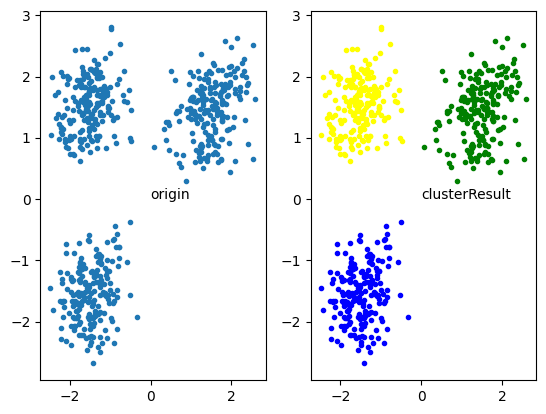

In [14]:
# Plot the result

plt.subplot(121)
plt.scatter(data_set[:, 0], data_set[:, 1], marker='.')
plt.text(0, 0, "origin")
plt.subplot(122)

scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'cyan', 'brown',
                 'chocolate', 'darkgreen', 'darkblue', 'azure', 'bisque']

for i in range(data_set.shape[0]):
    color = scatterColors[Label_pre[i]]
    plt.scatter(data_set[i, 0], data_set[i, 1], marker='.', c=color)

plt.text(0, 0, "clusterResult")
plt.show()

## References
* Paper: https://www.sciencedirect.com/science/article/pii/S0306437901000084
* Reference: https://github.com/Kchu/CURE-cluster-python

